In [1]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel
sample_max = int(1e5)

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "plots", "ksplots")).mkdir(exist_ok=True)
CWD

'/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from joblib import Parallel, delayed
os.chdir(CWD)
np.random.seed(0)

In [4]:
def parallel_process(r_prime, eta_prime, prior_cdf, n, ks_max, iterations, rounded):
    total_distance, total_pvalue = 0, 0
    r_prime = np.round(r_prime, rounded)
    eta_prime = np.round(eta_prime, rounded)

    for _ in range(iterations):
        obs_x = sample_prior(r_prime, eta_prime, size=n)
        filtered_x = np.sort(obs_x)[np.round(np.linspace(0, obs_x.size - 1, min(obs_x.size, ks_max))).astype(int)] 
        distance, _ = kstest_custom(filtered_x, prior_cdf)
        pvalue = 1 - stats.kstwo(n=n).cdf(distance)
        total_distance += distance
        total_pvalue += pvalue
    
    avg_distance = total_distance / iterations
    avg_pvalue = total_pvalue / iterations
    
    return [r_prime, eta_prime, avg_distance, avg_pvalue]

def nearby_df(r, eta, n=10000, ks_max=100000, r_bound=0.01, eta_bound=0.1, grid_amt=5, iterations=10, rounded=3):
    prior_cdf = compute_prior_cdf(r, eta, n_samples=1000, tail_percent=0.1, tail_bound=0.0001, debug=False, use_matlab=True, eng=eng)
    check_r = np.linspace(r - r_bound, r + r_bound, 2 * grid_amt + 1)
    check_eta = np.linspace(eta - eta_bound, eta + eta_bound, 2 * grid_amt + 1)

    results = Parallel(n_jobs=-1)(delayed(parallel_process)(r_prime, eta_prime, prior_cdf, n, ks_max, iterations, rounded) 
                                  for r_prime in check_r for eta_prime in check_eta)

    df = pd.DataFrame(results, columns=["r", "eta", "distance", "pvalue"])
    return df

# Example usage:

In [5]:
def KSHeatMapFullProcess(r, eta, n=10000, ks_max = 100000, r_bound=0.01, eta_bound =0.1, grid_amt= 5, iterations = 10, dist = True, pval = True, rounded = 4, accept_pval = 0.05, good_pct = 0.8, title= "", return_vals = False, print_messages = True, max_iterations = 6):
    if print_messages:
        print("Running process with original bounds")
    bound_divide = 2
    df = nearby_df(r=r, eta=eta, n=n, ks_max = ks_max, r_bound=r_bound, eta_bound=eta_bound, grid_amt = grid_amt, iterations= iterations, rounded=rounded)
    intial_fig = plotKSHeatMap(df=df, r=r, eta= eta, grid_amt = grid_amt, pval=pval, dist = dist, title = title + " Original Bounds")
    pass_pct = len(df[df["pvalue"] >= accept_pval])/len(df)
    initial_pct = pass_pct
    initial_r_bound = r_bound
    initial_eta_bound = eta_bound
    if pass_pct < good_pct:
        if print_messages:
            print(f"Only {pass_pct*100}% of tests passed with the original bounds. Now running with lower r and eta bounds")
        while pass_pct < good_pct and max_iterations>0:
            r_bound = r_bound/bound_divide
            eta_bound = eta_bound/bound_divide
            if bound_divide == 2:
                bound_divide = 5
            elif bound_divide == 5:
                bound_divide = 2
            if print_messages:
                print(f"Trying r_bound = {r_bound}, eta_bound = {r_bound}")
            df = nearby_df(r=r, eta=eta, n=n, ks_max = ks_max, r_bound=r_bound, eta_bound=eta_bound, grid_amt = grid_amt, iterations= iterations, rounded=rounded)
            pass_pct = len(df[df["pvalue"] >= accept_pval])/len(df)
            if pass_pct < good_pct:
                if print_messages:
                    print(f"Only {pass_pct*100}% of tests passed using r_bound = {r_bound}, eta_bound = {eta_bound}.Now running with lower r and eta bounds")
            else:
                if print_messages:
                    print(f"{pass_pct*100}% of tests passed using r_bound = {r_bound}, eta_bound = {eta_bound}. Showing Heatmaps")
                
            max_iterations -= 1
        final_fig = plotKSHeatMap(df=df, r=r, eta= eta, grid_amt = grid_amt, pval=pval, dist = dist, title = title+ " Final Bounds")
    else:
        if print_messages:
            print(f"{pass_pct*100}% of tests passed with the original bounds.")
    if return_vals:
        return [intial_fig, final_fig], [initial_r_bound, initial_eta_bound, initial_pct, r_bound, eta_bound, pass_pct]

In [6]:
data_dir = os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle')
group_data_map = pd.read_pickle(data_dir)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
full_params = pd.read_csv(Path(os.path.join(CWD, "CSVs", "optimized_params.csv")), index_col='layer')[["total_samples", "initial_r", "initial_eta", "kstest_stat_initial"]]
full_params["total_samples"] = full_params["total_samples"].astype(int)
full_params

,total_samples,initial_r,initial_eta,kstest_stat_initial
layer,,,,
2,3180,0.42,5.7,0.018069
3,12720,0.51,7.3,0.004615
4,50880,0.44,1.4,0.006270
5,203520,0.47,0.2,0.005236
6,814080,0.51,-0.6,0.004349
7,3256320,0.97,-0.9,0.010413
8,13025280,1.44,-1.2,0.051520


Running process with original bounds


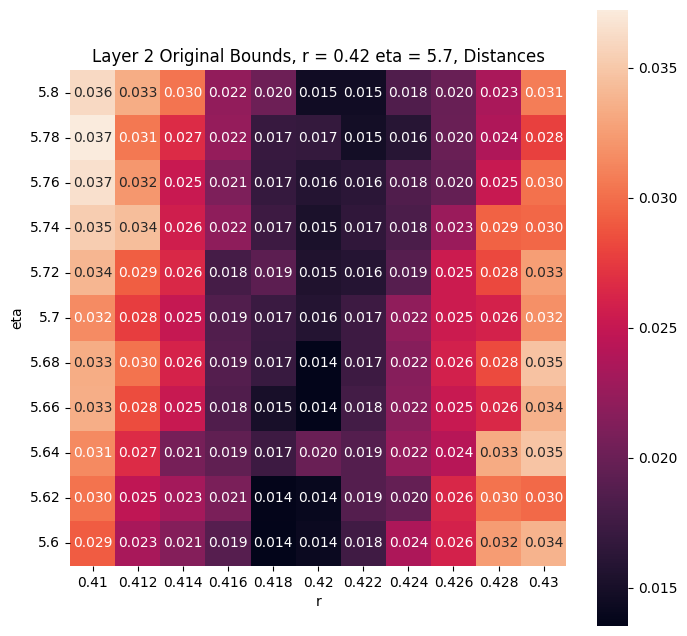

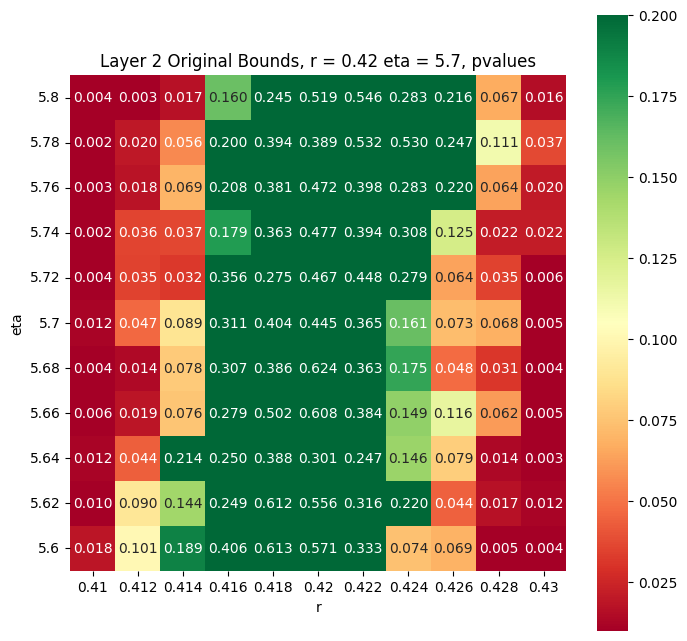

Only 65.28925619834712% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
100.0% of tests passed using r_bound = 0.005, eta_bound = 0.05. Showing Heatmaps


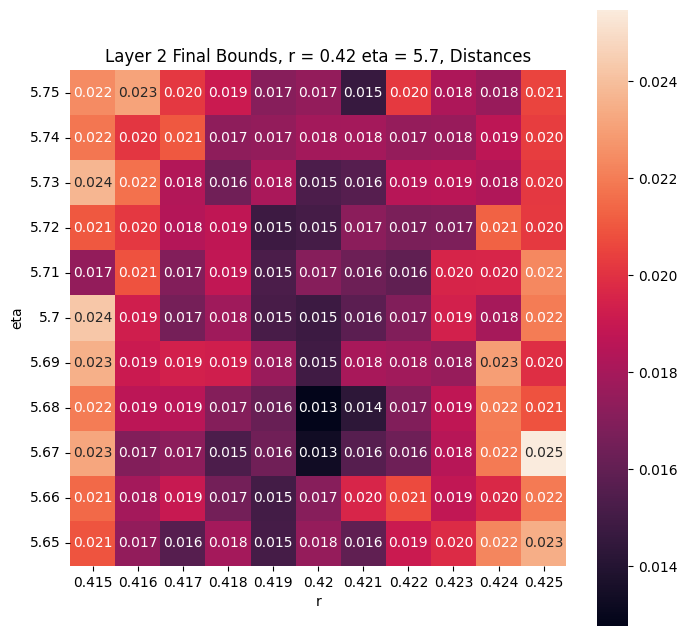

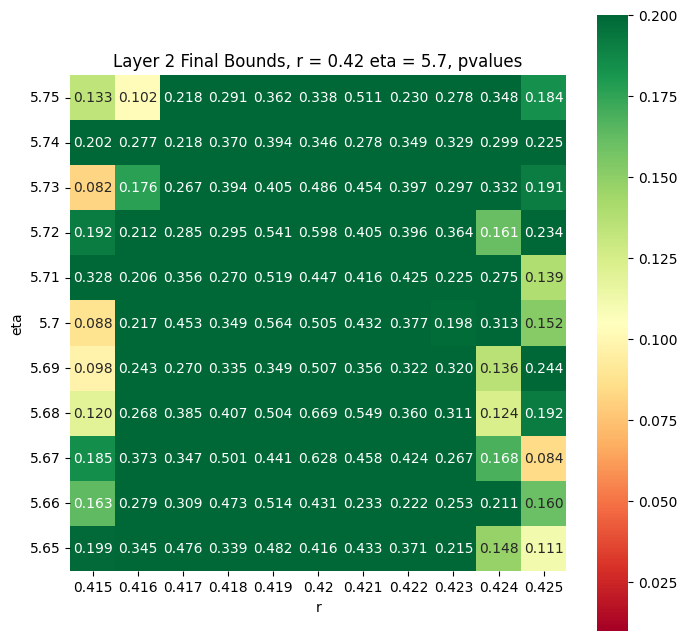

Running process with original bounds


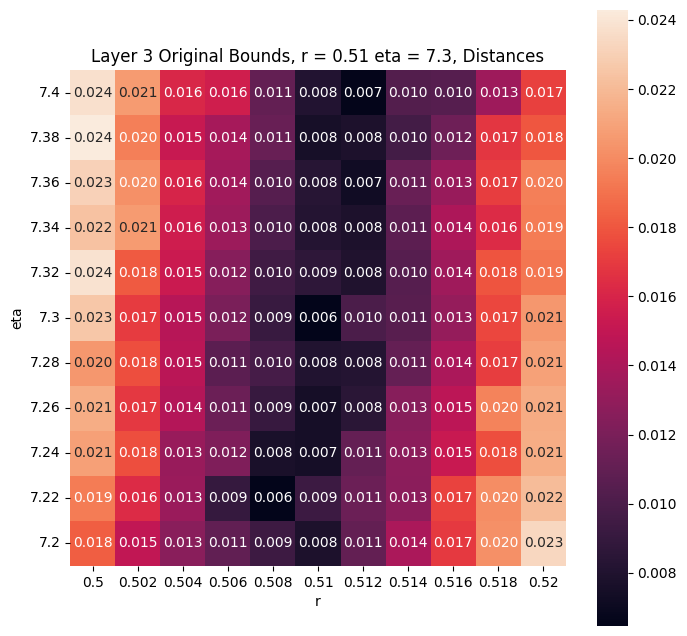

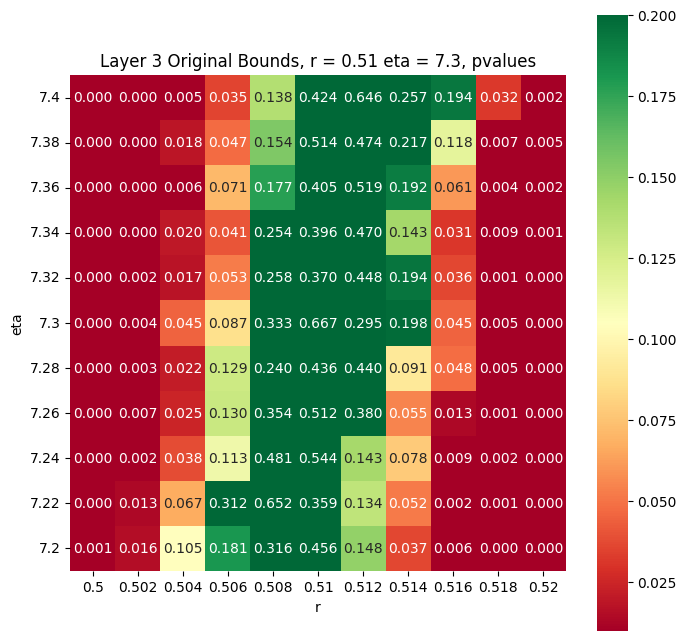

Only 46.28099173553719% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
90.9090909090909% of tests passed using r_bound = 0.005, eta_bound = 0.05. Showing Heatmaps


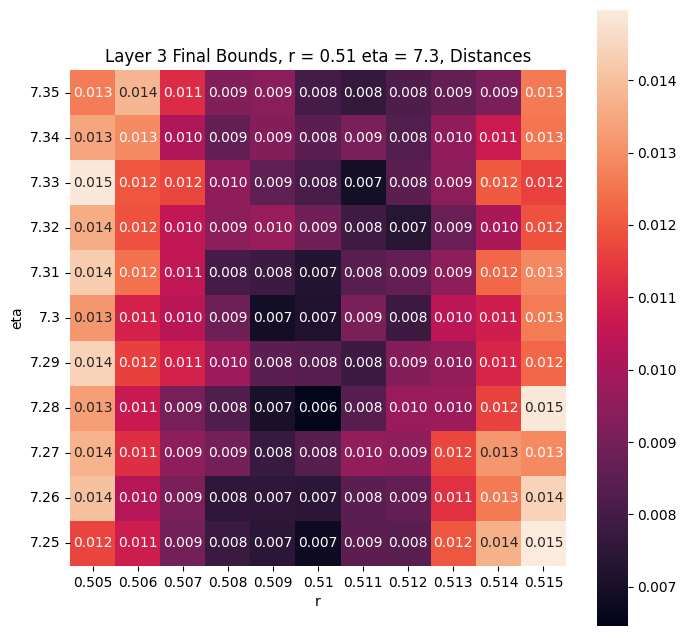

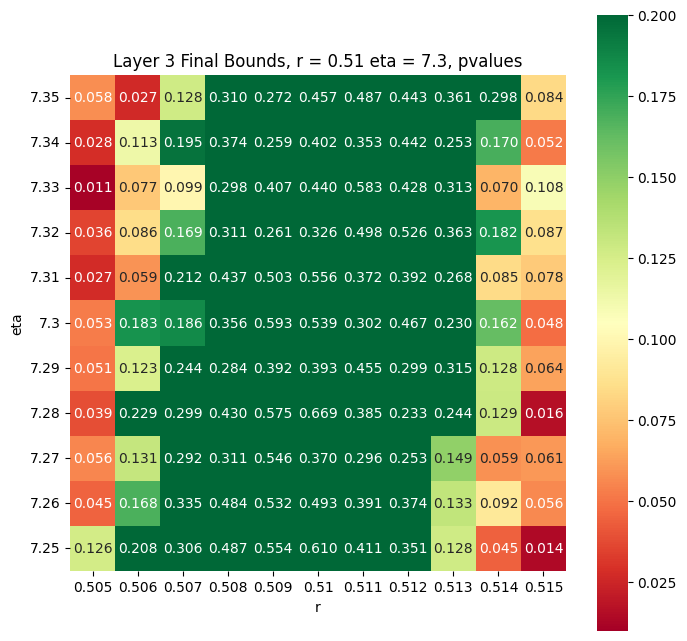

Running process with original bounds


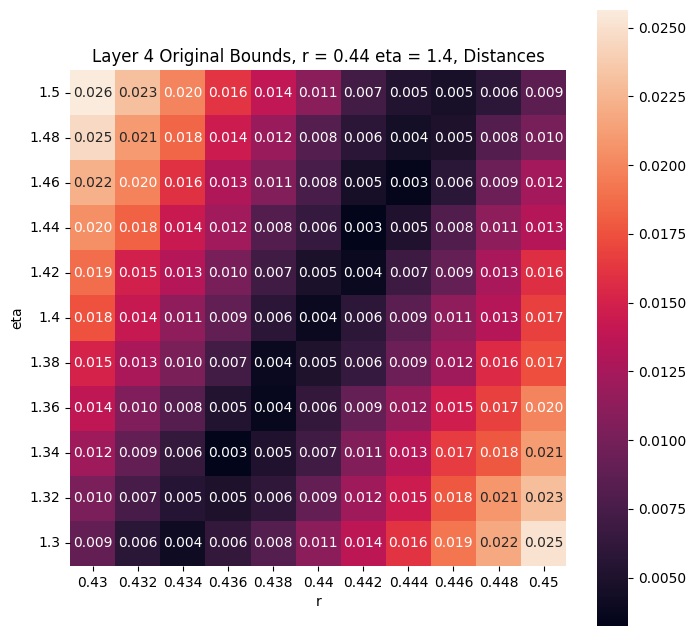

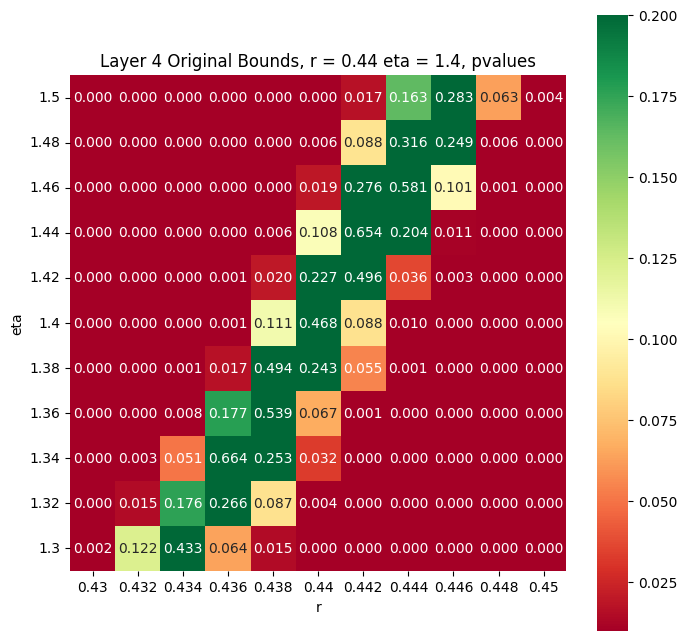

Only 26.446280991735538% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 52.066115702479344% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
100.0% of tests passed using r_bound = 0.001, eta_bound = 0.01. Showing Heatmaps


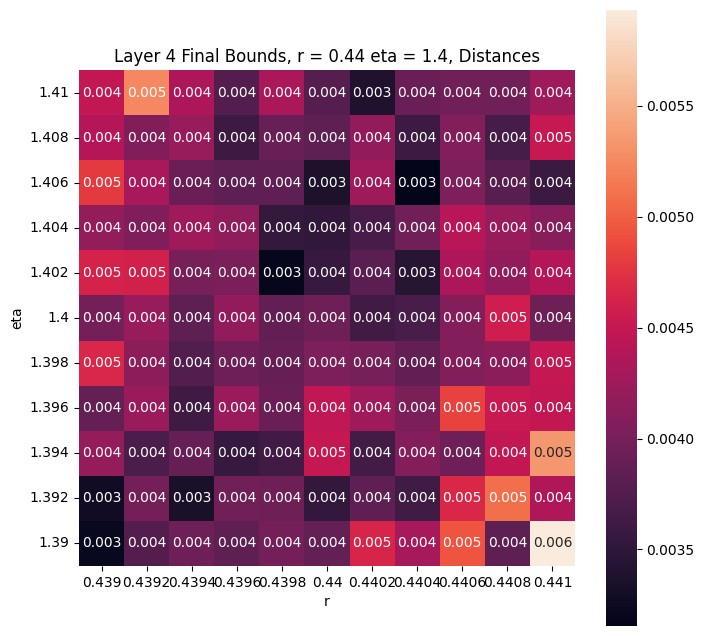

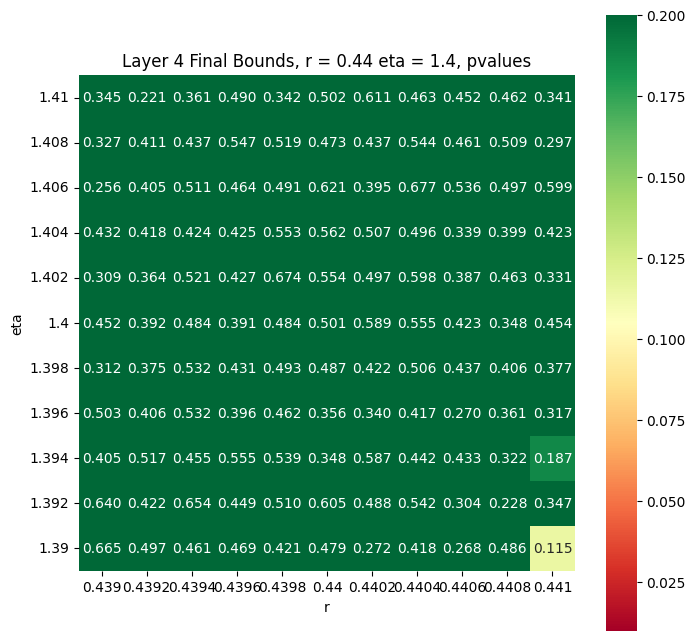

Running process with original bounds


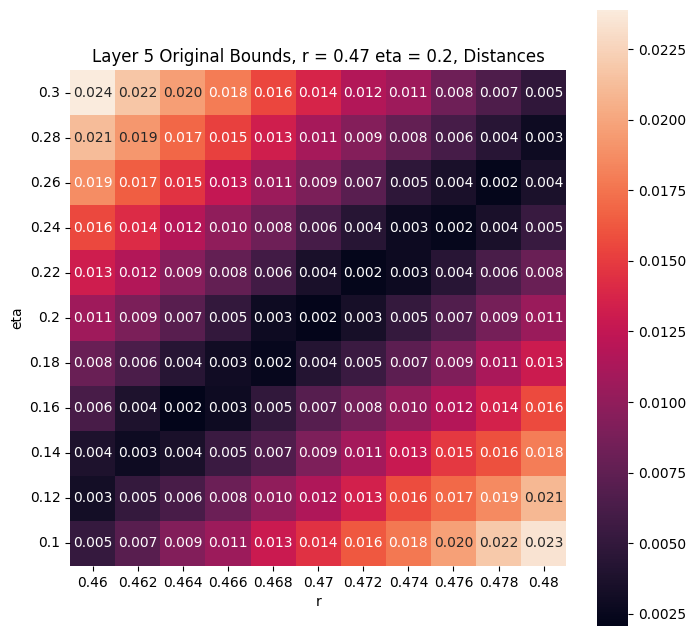

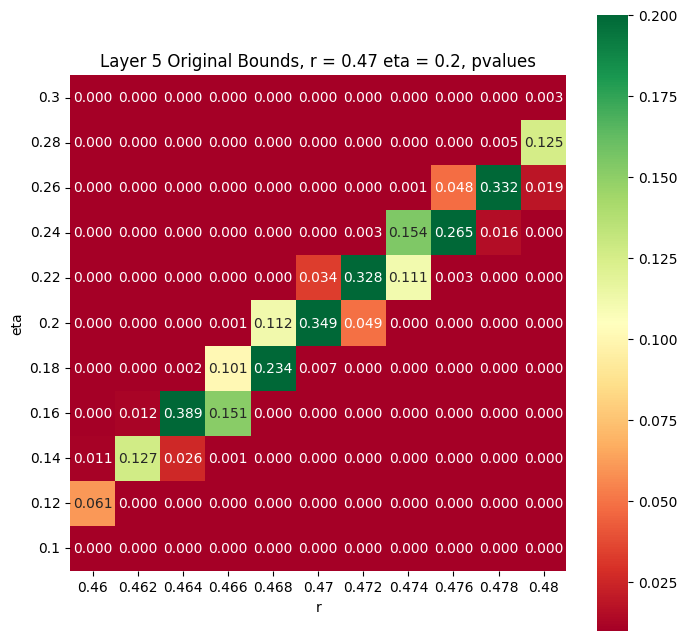

Only 11.570247933884298% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 28.92561983471074% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
95.86776859504133% of tests passed using r_bound = 0.001, eta_bound = 0.01. Showing Heatmaps


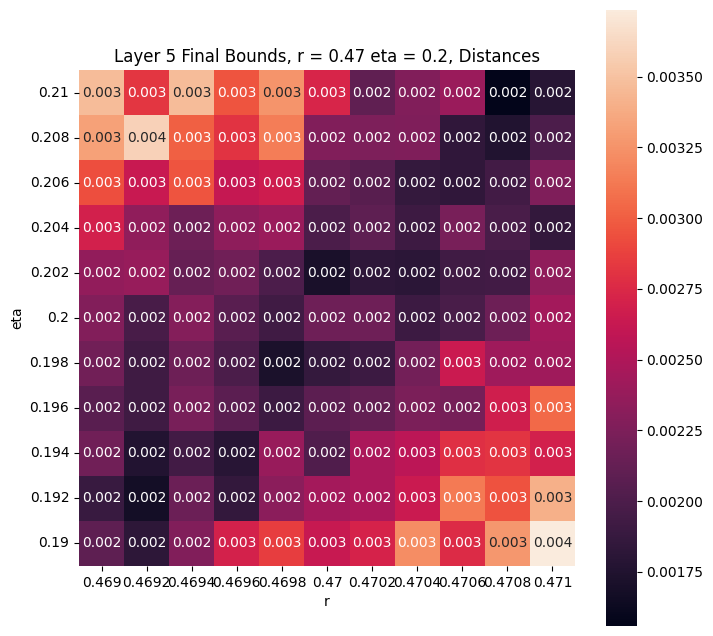

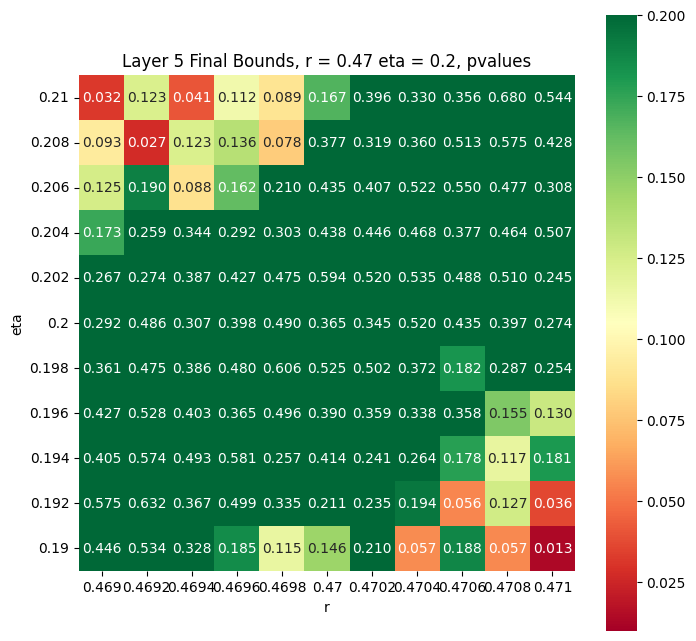

Running process with original bounds


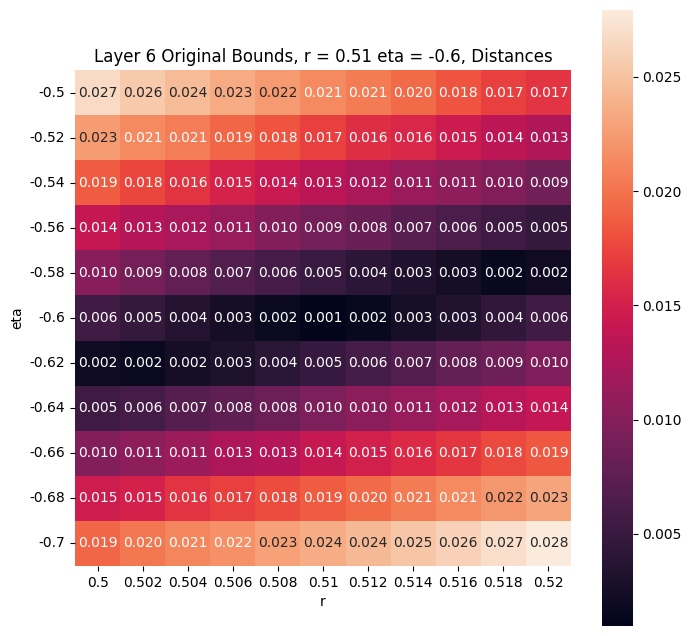

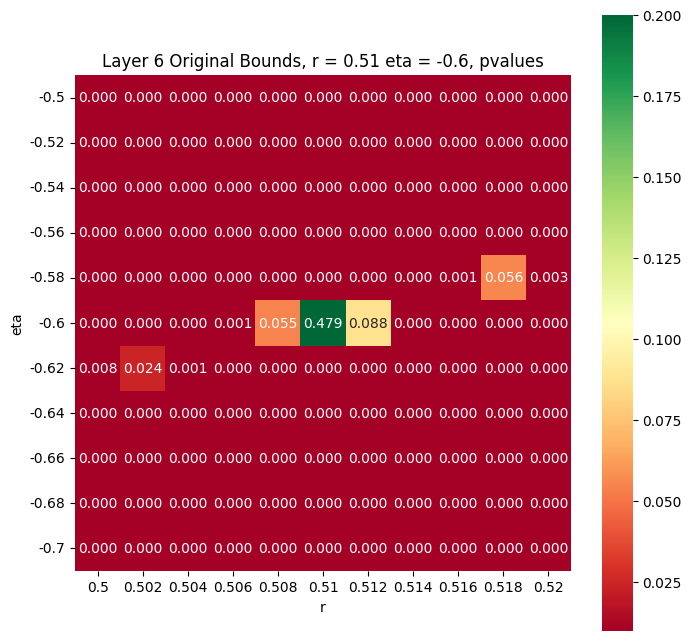

Only 3.3057851239669422% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 8.264462809917356% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
Only 42.97520661157025% of tests passed using r_bound = 0.001, eta_bound = 0.01.Now running with lower r and eta bounds
Trying r_bound = 0.0005, eta_bound = 0.0005
83.47107438016529% of tests passed using r_bound = 0.0005, eta_bound = 0.005. Showing Heatmaps


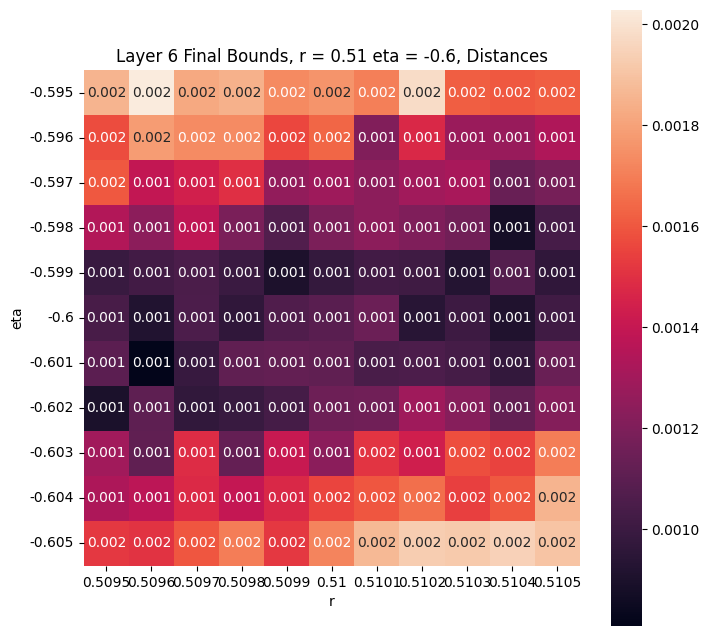

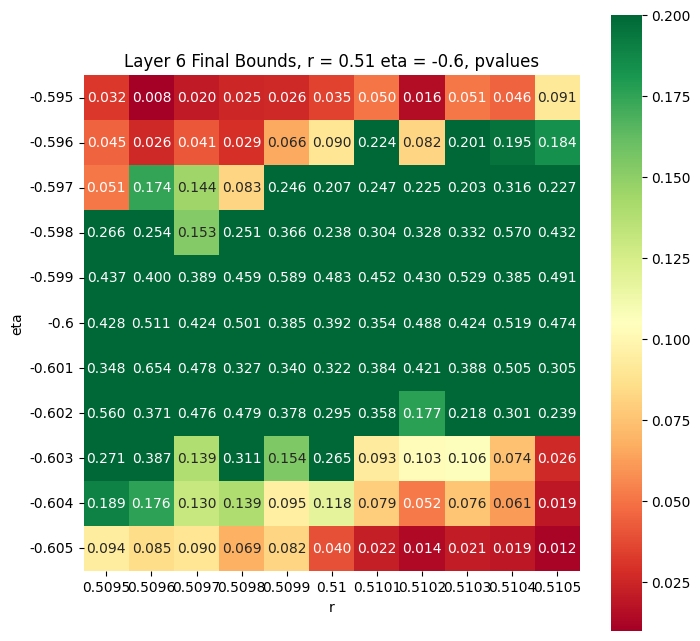

Running process with original bounds


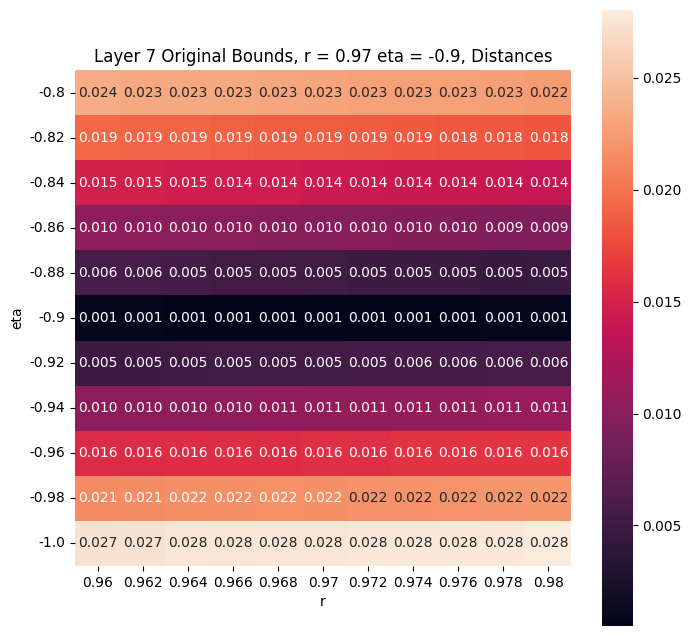

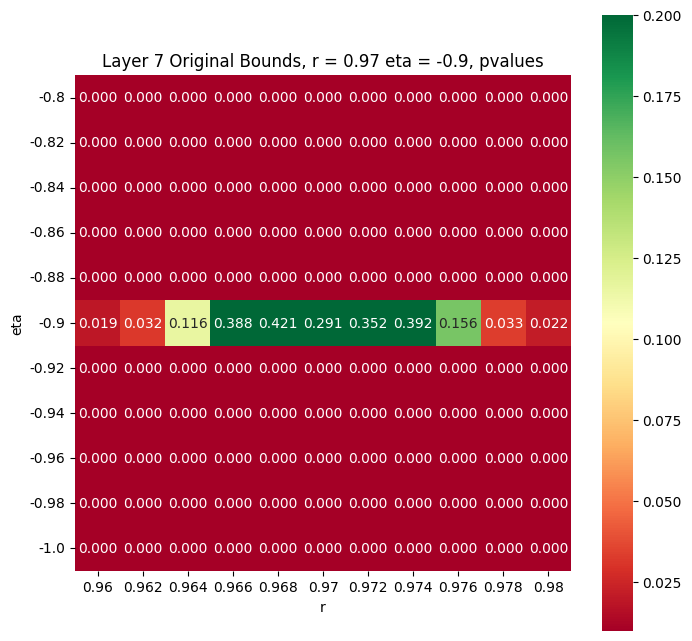

Only 5.785123966942149% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 9.090909090909092% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
Only 22.31404958677686% of tests passed using r_bound = 0.001, eta_bound = 0.01.Now running with lower r and eta bounds
Trying r_bound = 0.0005, eta_bound = 0.0005
Only 33.88429752066116% of tests passed using r_bound = 0.0005, eta_bound = 0.005.Now running with lower r and eta bounds
Trying r_bound = 0.0001, eta_bound = 0.0001
100.0% of tests passed using r_bound = 0.0001, eta_bound = 0.001. Showing Heatmaps


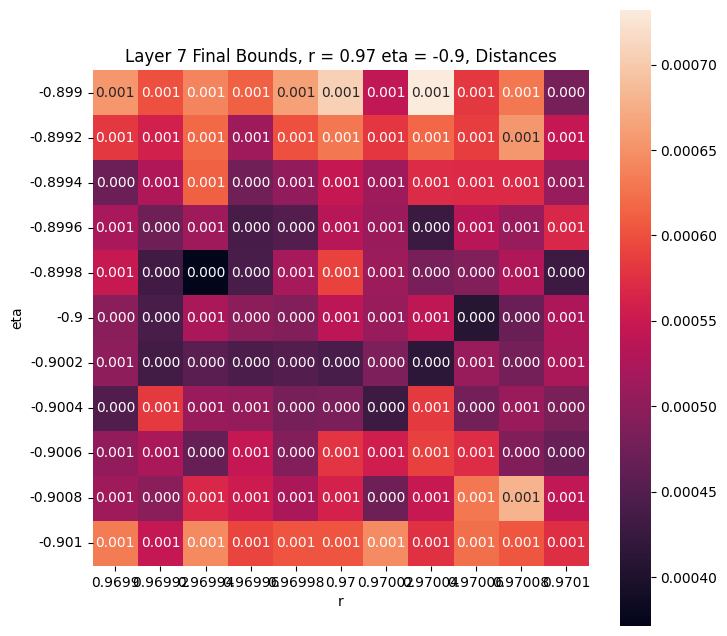

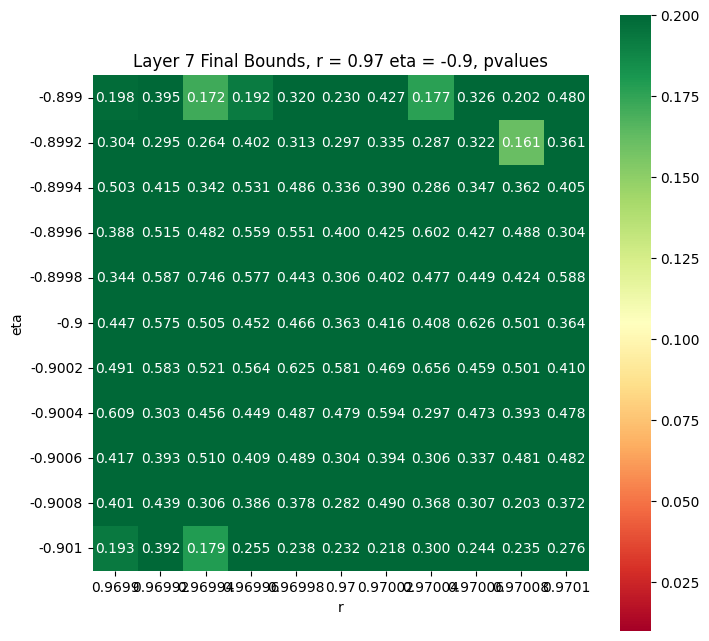

Running process with original bounds


/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


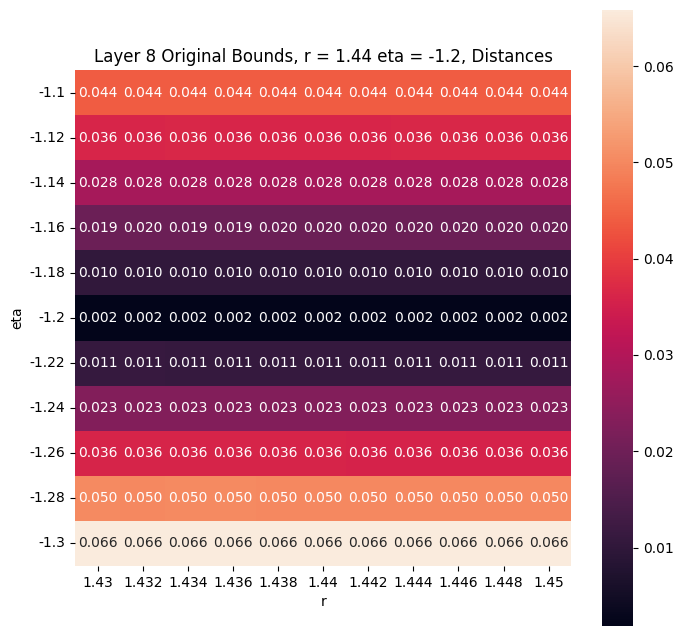

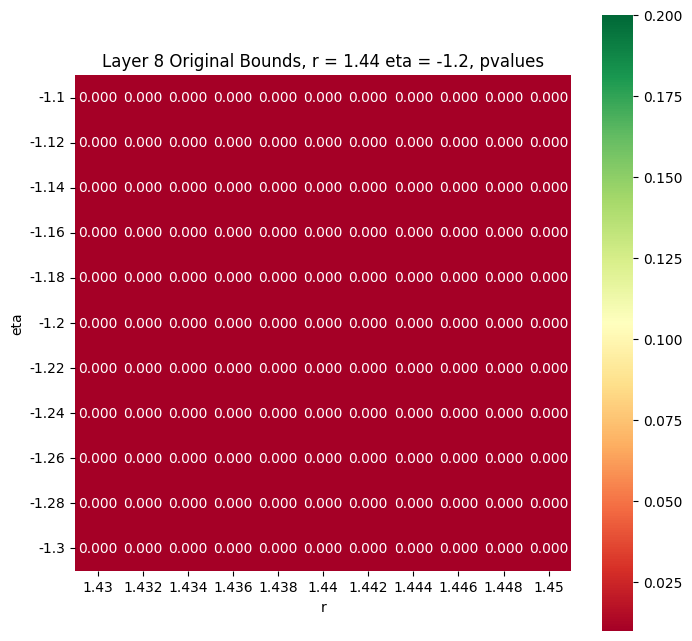

Only 0.0% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 0.0% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
Only 0.0% of tests passed using r_bound = 0.001, eta_bound = 0.01.Now running with lower r and eta bounds
Trying r_bound = 0.0005, eta_bound = 0.0005
Only 0.0% of tests passed using r_bound = 0.0005, eta_bound = 0.005.Now running with lower r and eta bounds
Trying r_bound = 0.0001, eta_bound = 0.0001
Only 0.0% of tests passed using r_bound = 0.0001, eta_bound = 0.001.Now running with lower r and eta bounds
Trying r_bound = 5e-05, eta_bound = 5e-05
Only 0.0% of tests passed using r_bound = 5e-05, eta_bound = 0.0005.Now running with lower r and eta bounds
Trying r_bound = 1e-05, eta_bound = 1e-05
Only 0.0% of tests passed using r_bound = 1e-05, eta_bound = 0.0001.Now running with lower r and eta bounds


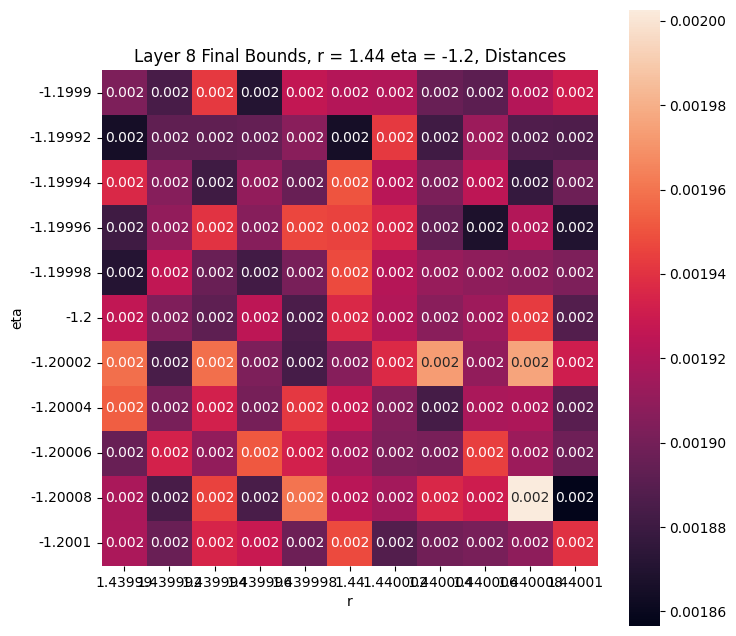

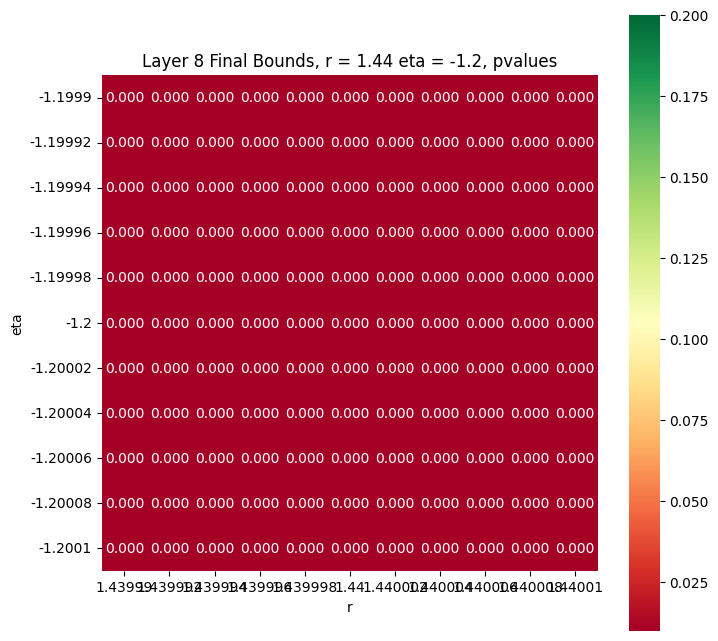

In [7]:
ks_output_df = pd.DataFrame(columns = ["layer", "inital_r_bound", "inital_eta_bound", "inital_pass_pct", "final_r_bound", "final_eta_bound", "final_pass_pct"])
for group in GROUPS:
    figs, output = KSHeatMapFullProcess(r = full_params.loc[group, 'initial_r'], eta = full_params.loc[group, 'initial_eta'], n = full_params.loc[group, 'total_samples'], ks_max = sample_max, iterations = 10, r_bound = 0.01, eta_bound=0.1, grid_amt = 5, rounded = 6, title = f"Layer {group}", return_vals = True, max_iterations = 6)
    figs[0][0].figure.savefig(os.path.join(CWD, "plots", "ksplots", f"ks_Plot_layer_{group}_initial_distances.jpg"), bbox_inches = 'tight', dpi=600)
    figs[0][1].figure.savefig(os.path.join(CWD, "plots", "ksplots", f"ks_plot_layer_{group}_initial_dvalues.jpg"), bbox_inches = 'tight', dpi=600)
    figs[1][0].figure.savefig(os.path.join(CWD, "plots", "ksplots", f"ks_plot_layer_{group}_final_distances.jpg"), bbox_inches = 'tight', dpi=600)
    figs[1][1].figure.savefig(os.path.join(CWD, "plots", "ksplots", f"ks_plot_layer_{group}_final_pvalues.jpg"), bbox_inches = 'tight', dpi=600)
    ks_output_df.loc[len(ks_output_df)] = [group] + output


In [8]:
group = 8
r = full_params.loc[group, 'initial_r'] 
eta = full_params.loc[group, 'initial_eta'] 
n = full_params.loc[group, 'total_samples']
ks_max = sample_max
prior_cdf = compute_prior_cdf(r, eta, n_samples= 1000, tail_percent=.1, tail_bound= 0.0001, debug = False, use_matlab=True, eng = eng)

In [9]:

obs_x = sample_prior(r, eta, size = n)
filtered_x = np.sort(obs_x)[np.round(np.linspace(0, obs_x.size - 1, min(obs_x.size, ks_max))).astype(int)]

In [10]:
distance, _ = kstest_custom(filtered_x, prior_cdf)
pvalue = 1 - stats.kstwo(n=n).cdf(distance)

Running process with original bounds


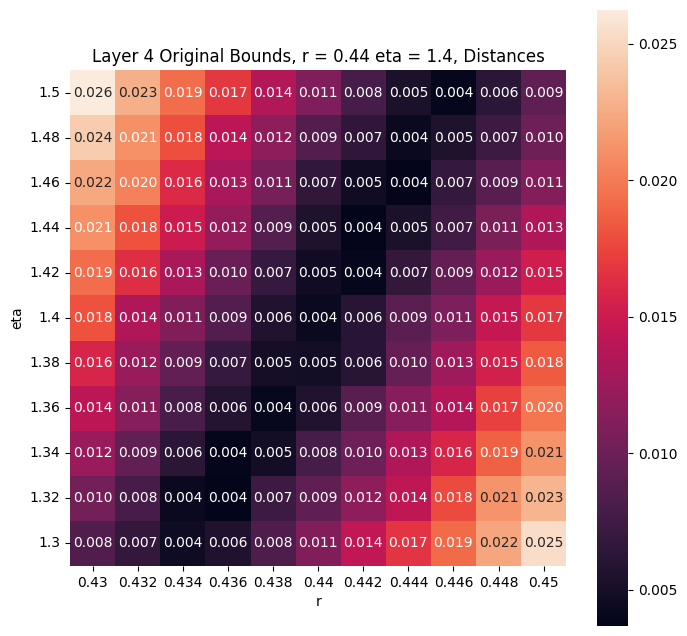

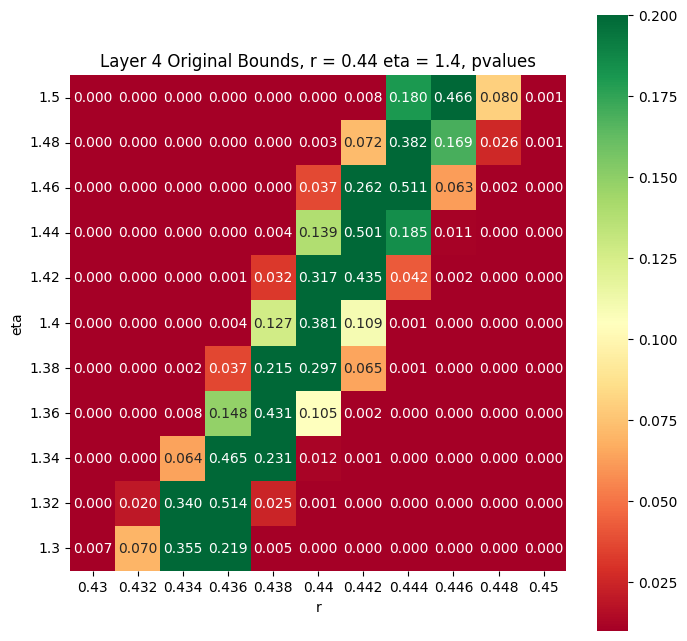

Only 25.6198347107438% of tests passed with the original bounds. Now running with lower r and eta bounds
Trying r_bound = 0.005, eta_bound = 0.005
Only 52.892561983471076% of tests passed using r_bound = 0.005, eta_bound = 0.05.Now running with lower r and eta bounds
Trying r_bound = 0.001, eta_bound = 0.001
100.0% of tests passed using r_bound = 0.001, eta_bound = 0.01. Showing Heatmaps


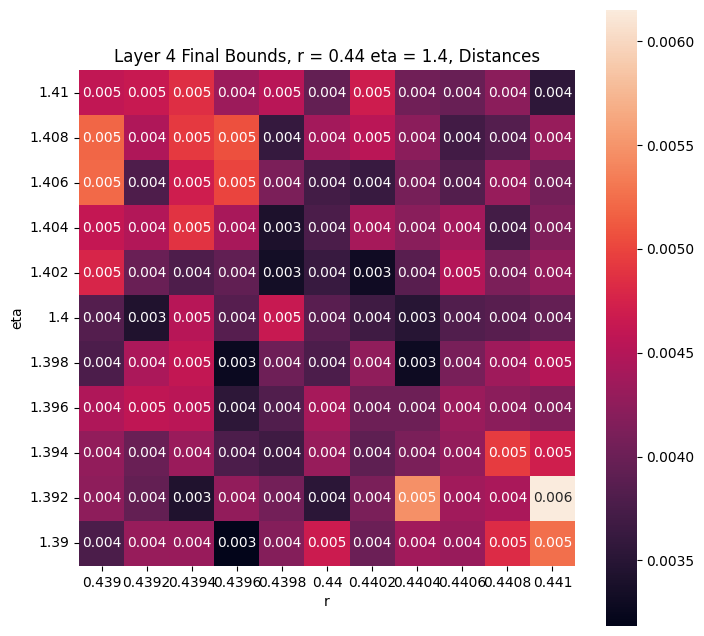

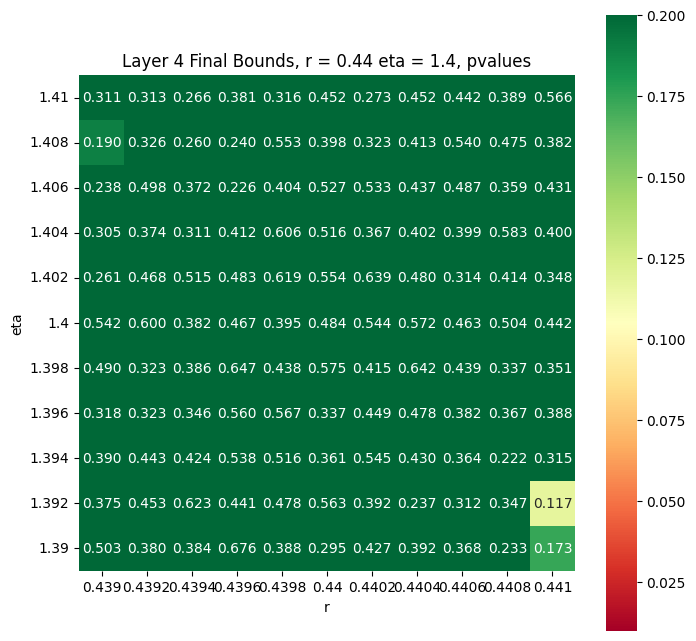

In [11]:
group = 4

figs, output = KSHeatMapFullProcess(r = full_params.loc[group, 'initial_r'], eta = full_params.loc[group, 'initial_eta'], n = full_params.loc[group, 'total_samples'], ks_max = sample_max, iterations = 10, r_bound = 0.01, eta_bound=0.1, grid_amt = 5, rounded = 6, title = f"Layer {group}", return_vals = True, max_iterations = 6)

In [12]:
ks_output_df.to_csv(os.path.join(CWD, "CSVs", 'KS_plot_df.csv'))
